# Demo: Polynomial curve fitting (Lecture 1)
This Jupyter notebook accompanies Lecture 1 of Computer Science in Mechanical Engineering II (CSME II).
By loading it in Jupyter or Jupyter Lab you can rerun it on your own and also modify it.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Introduction
We set a seed for reproducability.

In [2]:
np.random.seed(123456)

## Setting up the example
Our running example is the function $f: [0,1] \rightarrow \mathbb{R}$ with $f(x)=\sin(2\pi x)$,
which is our fixed, but unknown ground truth.
We have data $(x_1,y_1),\ldots,(x_N,y_N)$, where $x_i$ are equi-distant inputs from $[0,1]$ and $y_i=f(x_i)+\epsilon_i$,
with $\epsilon_1,\ldots,\epsilon_N$ i.i.d. normally distributed.

Let's generate a data set with $N=10$ samples.

In [3]:
# We use this grid for evaluating the function
n_grid = 1000
xs = np.linspace(0,1,n_grid)
ys = np.sin(2*np.pi*xs)

# Start with a small training data set
n_train = 10
noise_sd = 0.2
xs_train = np.linspace(0,1,n_train)
ys_train = np.sin(2*np.pi*xs_train) + np.random.normal(loc=0, scale=noise_sd, size=n_train)

Below we plot the function (solid green) and the data set (blue dots).

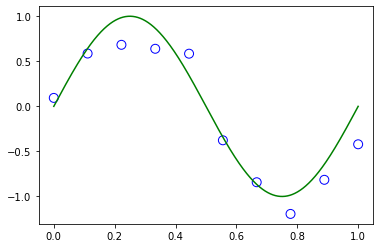

In [4]:
plt.plot(xs, ys, 'g')
plt.scatter(xs_train, ys_train, s=80, facecolors='none', edgecolor='blue')

## Fitting polynomials
First, we fit polynomials of various degrees $M$ to the data using the least squares criterion (to be developed later in class).

In [5]:
# Fit coefficients
n_degree_max = 9
regression_mat = np.vander(xs_train, n_degree_max+1, increasing=True)
coeffs = np.zeros([n_degree_max+1, n_degree_max+1])
for i in range(n_degree_max+1):
    coeffs[:(i+1),i] = np.linalg.lstsq(regression_mat[:,:(i+1)], ys_train, rcond=None)[0]

# For later: Training error (RMS)
train_error = np.linalg.norm(regression_mat @ coeffs - ys_train.reshape([-1,1]), axis=0, ord=2)/np.sqrt(n_train)

# Helper function for plotting
plot_mat = np.vander(xs, n_degree_max+1, increasing=True) 
ind_test = np.ceil(0.05*n_grid)
ind_test = ind_test.astype(int)
def plot_fit(i_degree):
    fig = plt.figure(figsize=(5,5))
    ys_fit = plot_mat @ coeffs[:,i_degree]
    plt.plot(xs, ys, 'g')
    plt.scatter(xs_train, ys_train, s=80, facecolors='none', edgecolor='blue')
    plt.plot(xs, ys_fit, 'r')
    plt.scatter(xs[ind_test], ys_fit[ind_test], s=80, facecolors='red', edgecolor='red')
    plt.text(0.9, 0.9, f'$M={i_degree}$')
    plt.xlim([-0.1, 1.1])
    plt.ylim([-1.5, 1.5])

The function ``plot_fit(M)`` can be used to fit polynomial of degree $M$.

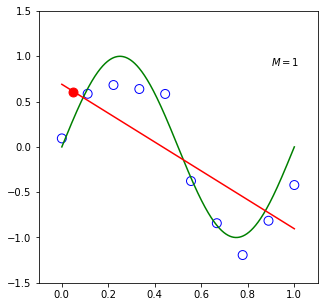

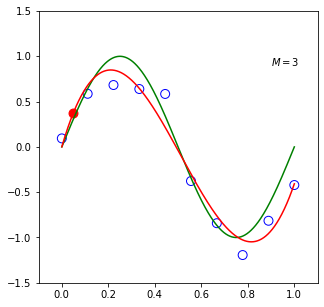

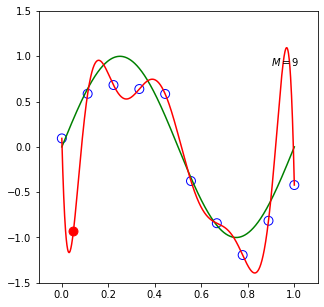

In [6]:
# plot_fit(M) -> M degree of polynomial
# demo: Choose M=0,1,... here.
#plot_fit(9)
plot_fit(1)
plot_fit(3)
plot_fit(9)

-------------

## Evaluating the test error
In order to evaluate the test error we generate test data, i.e. new independent data from the same ground truth.

In [7]:
n_test = 100
ind_test = np.random.choice(np.arange(n_grid), n_test, replace=False)
xs_test = xs[ind_test]
ys_test = ys[ind_test] + np.random.normal(loc=0, scale=noise_sd, size=n_test)

Now we calculate the test error, i.e. the error made by our learnt model on the test data, and compare with training error.

In [8]:
input_mat_test = np.vander(xs_test, n_degree_max+1, increasing=True)
test_error = np.linalg.norm(input_mat_test @ coeffs - ys_test.reshape([-1,1]), axis=0, ord=2)/np.sqrt(n_test)

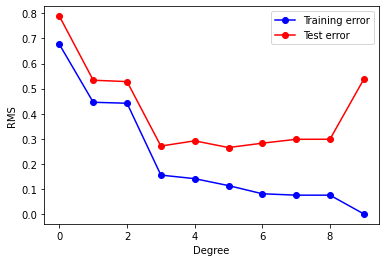

In [9]:
#plt.figure(figsize=(8,8))
plt.plot(np.arange(0, n_degree_max+1), train_error, '-ob')
plt.plot(np.arange(0, n_degree_max+1), test_error, '-or')
plt.xlabel('Degree')
plt.ylabel('RMS')
_ = plt.legend(['Training error', 'Test error'])

What's happening? Let us inspect the coefficients.

In [10]:
print_degrees = [0,1,3,9]
with np.printoptions(precision=2, suppress=True):
    print(coeffs[:,print_degrees])


[[     -0.11       0.69       0.         0.09]
 [      0.        -1.59       8.82     -96.97]
 [      0.         0.       -26.38    2415.46]
 [      0.         0.        17.15  -22361.13]
 [      0.         0.         0.    106844.61]
 [      0.         0.         0.   -294368.65]
 [      0.         0.         0.    485271.96]
 [      0.         0.         0.   -472395.34]
 [      0.         0.         0.    250366.51]
 [      0.         0.         0.    -55676.95]]


---

## How to deal with overfitting?
### Option 1: Use more data  
We repeat the fitting, but this time with larger training data sets.

In [11]:
def fit_and_plot(n_train):
    np.random.seed(123456)   # comment if you want to create different data each time
    xs_train = np.linspace(0,1,n_train)
    ys_train = np.sin(2*np.pi*xs_train) + np.random.normal(loc=0, scale=noise_sd, size=n_train)
    
    regression_mat = np.vander(xs_train, n_degree_max+1, increasing=True)
    coeffs = np.linalg.lstsq(regression_mat, ys_train, rcond=None)[0]
    ys_fit = plot_mat @ coeffs
    
    plt.figure(figsize=(5,5))
    plt.plot(xs, ys, 'g')
    plt.scatter(xs_train, ys_train, s=80, facecolors='none', edgecolor='blue')
    plt.plot(xs, ys_fit, 'r')
    plt.text(0.9, 0.9, f'$N={n_train}$')
    plt.xlim([-0.1, 1.1])
    plt.ylim([-1.5, 1.5])

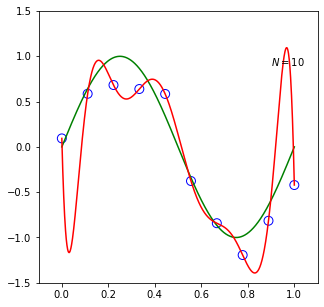

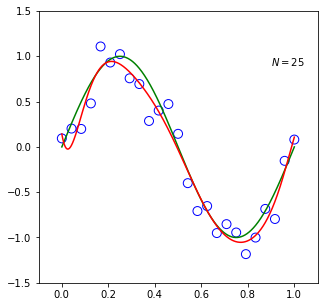

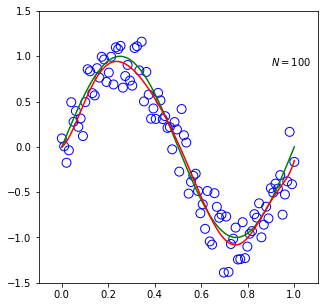

In [12]:
fit_and_plot(10)
fit_and_plot(25)
fit_and_plot(100)

---

### Option 2: Use regularization
We now use a regularized least squares criterion for fitting. We fix the maximal order $M$,
training set $N$ and consider different regularization parameters $\lambda$.

In [13]:
def fit_and_plot_regularized(lambda_reg):
    coeffs_reg = np.linalg.lstsq(regression_mat.T @ regression_mat + lambda_reg*np.identity(n_degree_max + 1),
                                 regression_mat.T @ ys_train,
                                 rcond=None)[0]
    fig = plt.figure(figsize=(5,5))
    ys_fit = plot_mat @ coeffs_reg.reshape([-1,1])
    plt.plot(xs, ys, 'g')
    plt.scatter(xs_train, ys_train, s=80, facecolors='none', edgecolor='blue')
    plt.plot(xs, ys_fit, 'r')
    plt.text(0.7, 0.9, f'$\lambda={lambda_reg}$')
    #plt.text(0.7, 0.9, f'$\log\lambda={np.log(lambda_reg)}$')
    plt.xlim([-0.1, 1.1])
    plt.ylim([-1.5, 1.5])

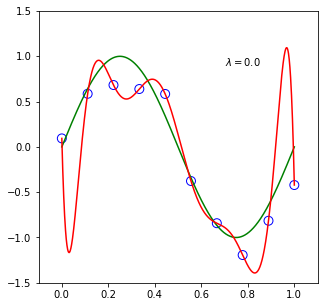

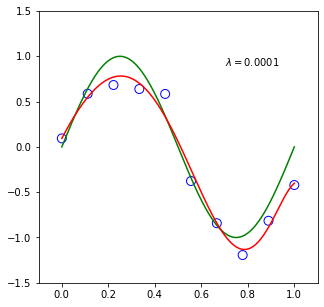

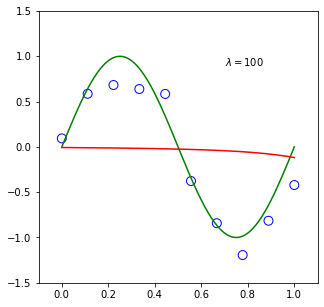

In [14]:
fit_and_plot_regularized(0.)
fit_and_plot_regularized(1e-4)
fit_and_plot_regularized(100)